In [183]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import json

In [184]:
import tensorflow as tf

from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D;
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers

In [185]:
with open("tokenizerRed.json", "r") as jsonfile:
    tokenizer = json.load(jsonfile)

tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer)

In [186]:
with open("dados/tituloTratadoRed.csv", "r") as csvfile:
    titulos = np.genfromtxt(csvfile, delimiter=",")
    titulos = titulos.astype(np.int32)

In [187]:
with open("dados/conteudoTratadoRed.csv", "r") as csvfile:
    conteudos = np.genfromtxt(csvfile, delimiter=",")
    conteudos = conteudos.astype(np.int32)

In [188]:
size = len(conteudos)

xTrain = conteudos[0:int(size*0.8)]
xTest = conteudos[int(size*0.8):]

In [189]:
vocab = len(tokenizer.word_index)

In [190]:
vocab

7392

In [191]:
maxContent = max(len(tokens) for tokens in conteudos)

In [192]:
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z = mu + sigma * epsilon"""

  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [193]:
def Encoder(latentDim, encoderInputs):
    
  l1 = keras.models.Sequential([
    layers.Embedding(vocab, 128, input_length=maxContent),
    layers.Conv1D(128, 3, activation="relu", strides=1, padding="same"),
    layers.MaxPooling1D(3),
    layers.Conv1D(64, 3, activation="relu", strides=1, padding="same"),
    layers.MaxPooling1D(3),
    layers.Flatten(),
    layers.Dense(256, activation="relu")
  ])

  x = l1(encoderInputs)

  zMean = layers.Dense(latentDim, name="z_mean")(x)
  zLogVar = layers.Dense(latentDim, name="z_log_var")(x)

  z = SamplingLayer()([zMean, zLogVar])

  return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")

encoderInputs = keras.Input(shape=(maxContent, 1))
encoder = Encoder(2, encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 2141, 1)]            0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 256)                  4903360   ['input_3[0][0]']             
                                                                                                  
 z_mean (Dense)              (None, 2)                    514       ['sequential_2[0][0]']        
                                                                                                  
 z_log_var (Dense)           (None, 2)                    514       ['sequential_2[0][0]']        
                                                                                            

In [194]:
def Decoder(latentInputs):

  l1 = keras.models.Sequential([
    layers.Dense(maxContent, activation="relu", input_shape=(latentInputs.shape[1],)),
    layers.Reshape((maxContent, 1)),
    layers.Conv1DTranspose(128, 3, activation="relu", strides=1, padding="same"),
    layers.Conv1DTranspose(64, 3, activation="relu", strides=1, padding="same"),
    layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same", input_shape=(None, maxContent))
  ])

  return keras.Model(latentInputs, l1(latentInputs), name="decoder")

latentInputs = keras.Input(shape=(2,))
decoder = Decoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_3 (Sequential)   (None, 2141, 1)           31768     
                                                                 
Total params: 31768 (124.09 KB)
Trainable params: 31768 (124.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [195]:
def reconstructionLoss(data, reconstructed):
  return keras.losses.binary_crossentropy(data, reconstructed)   

In [196]:
def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
        -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
        axis=1
  )

In [197]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return  loss1, loss2, loss1 + klWeight * loss2

In [198]:
print(xTrain.shape, "\n", yTrain.shape)

(78, 2141) 
 (78, 15, 1)


In [199]:
xTrain = np.expand_dims(xTrain, -1).astype("float32") / vocab
xTest = np.expand_dims(xTest, -1).astype("float32") / vocab

In [200]:
print(xTrain.shape, "\n", yTrain.shape)

(78, 2141, 1) 
 (78, 15, 1)


In [201]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")
    
  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]

  def train_step(self, data):

    with tf.GradientTape() as tape:
        
        zMean, zLogVar, z = self.encoder(data)
        reconstruction = self.decoder(z)

        ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)

    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }

In [203]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history = vae.fit(xTrain, epochs=10, batch_size=1)

Epoch 1/10
78/78 [==============================] - 6s 46ms/step - total_loss: 0.1041 - ce_loss: 0.1041 - kl_loss: 7.0735e-06
Epoch 2/10
78/78 [==============================] - 4s 46ms/step - total_loss: 0.1019 - ce_loss: 0.1018 - kl_loss: 3.8172e-06
Epoch 3/10
78/78 [==============================] - 4s 47ms/step - total_loss: 0.1011 - ce_loss: 0.1011 - kl_loss: 2.8650e-06
Epoch 4/10
78/78 [==============================] - 3s 45ms/step - total_loss: 0.1036 - ce_loss: 0.1036 - kl_loss: 3.7073e-06
Epoch 5/10
78/78 [==============================] - 4s 45ms/step - total_loss: 0.1007 - ce_loss: 0.1007 - kl_loss: 1.5274e-06
Epoch 6/10
78/78 [==============================] - 4s 45ms/step - total_loss: 0.1020 - ce_loss: 0.1020 - kl_loss: 1.1617e-06
Epoch 7/10
78/78 [==============================] - 4s 46ms/step - total_loss: 0.1002 - ce_loss: 0.1002 - kl_loss: 1.0429e-06
Epoch 8/10
78/78 [==============================] - 4s 45ms/step - total_loss: 0.0997 - ce_loss: 0.0997 - kl_loss: 2.1

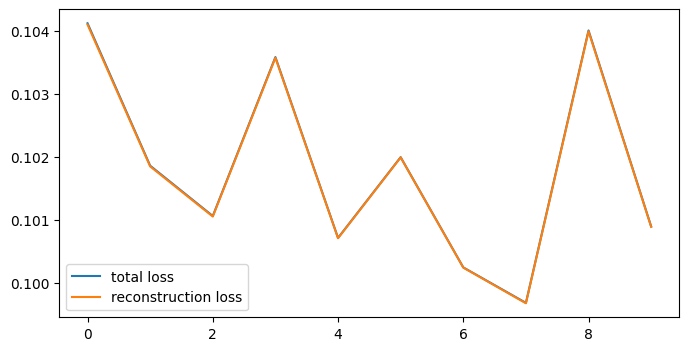

In [204]:
plt.figure(figsize=(8, 4))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
#plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

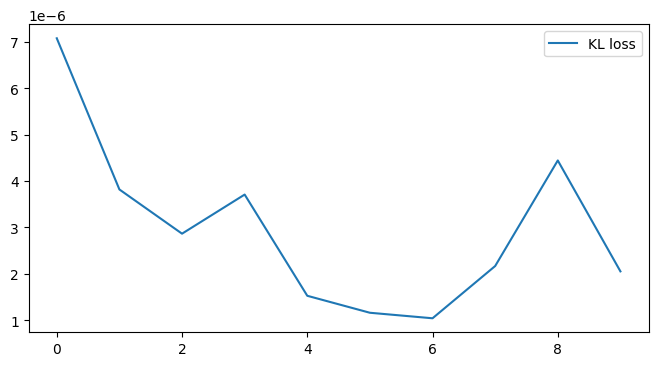

In [205]:
plt.figure(figsize=(8, 4))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

In [218]:
idx = 14
inputPredict = xTest[idx]
inputPredict = inputPredict.reshape(1, maxContent)

In [219]:
z = vae.encoder.predict([inputPredict])[2]

1/1 [==============================] - 0s 50ms/step


In [220]:
#z = np.random.normal(loc=0, scale=4, size=(1,2))

In [221]:
z

array([[0.551951 , 0.7350975]], dtype=float32)

In [222]:
teste = vae.decoder.predict(z)

1/1 [==============================] - 0s 40ms/step


In [223]:
teste = teste.reshape(maxContent)

In [224]:
teste*vocab

array([976.67773  , 551.78577  , 559.14984  , ...,   1.59081  ,
         2.8100133,  69.911865 ], dtype=float32)

In [225]:
prediction = (teste*vocab).tolist()
for x in range(maxContent):
    prediction[x] = round(prediction[x])

predictionsText = tokenizer.sequences_to_texts([prediction])

In [226]:
content = xTest[idx].reshape(maxContent)
content = (content*vocab).tolist()

for x in range(maxContent):
    content[x] = round(content[x])

content = tokenizer.sequences_to_texts([content])

In [227]:
content

['treinador de muay thai de anderson silva desde 2011 quando o então detentor do cinturão dos pesos médios do ultimate enfrentou e venceu vitor belfort com um espetacular chute no rosto pedro rizzo estava no córner do paulista no ufc 168 dia 28 de dezembro de 2013 em las vegas eua a imagem do ex campeão da categoria até 84kg gritando de dor pela perna quebrada após chutar o joelho de chris weidman trouxe más lembranças ao ex peso pesado do ufc não por já ter sentido a dor de anderson silva mas sim por já ter estado na pele do americano quando ainda competia campeonatos de muay thai por isso o brasileiro é categórico ao afirmar que o campeão peso médio no fundo não deve se considerar vitorioso no combate isso aconteceu comigo quando eu lutei muay thai na bélgica foi a mesma lesão porque meu adversário chutou eu bloqueei e ele quebrou a perna foi um acidente e por isso não considero que tenha sido uma vitória ou um nocaute apenas aconteceu foi algo realmente muito ruim e não se deve come

In [228]:
predictionsText

['ajustes pelos bloco sochi abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura abertura 